In [1]:
import time
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bt
import h5py

from datetime import datetime
import yfinance as yf

In [2]:
tickers_new = 'aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn'
data = bt.get(
    tickers_new,
    start='2010-01-01',
    end = '2022-07-01'
)
data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn
Date,,,,,,,,,,,,,,
2010-01-04,6.478999,23.474918,26.893311,136.536926,67.992668,42.974461,40.160072,18.498018,6.695000,29.669851,37.090000,23.853477,27.843176,18.196344
2010-01-05,6.490200,23.482506,27.921576,138.950836,68.344696,42.476154,40.173203,18.274250,6.734500,30.244543,37.700001,23.782902,27.773720,18.091410
2010-01-06,6.386965,23.338392,28.791641,137.467834,67.992668,42.821640,39.982658,18.267767,6.612500,30.410732,37.619999,23.748518,27.626127,17.958490
2010-01-07,6.375157,23.095682,28.870760,140.157852,71.513321,42.516018,39.765816,18.222366,6.500000,31.013124,36.889999,23.593332,27.634811,18.014452
2010-01-08,6.417540,23.254953,28.396175,137.507263,73.053596,42.662178,39.713257,17.885094,6.676000,30.936954,36.689999,23.601692,27.678217,18.427210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,140.444199,264.041077,44.782074,289.352966,52.030651,174.613434,138.010956,60.242382,116.459999,111.237900,387.720001,326.949310,97.462357,149.027618
2022-06-27,140.444199,261.269440,44.754002,287.470154,51.805435,174.450592,136.959259,60.118153,113.220001,110.346634,381.070007,325.297272,96.296165,148.712265
2022-06-28,136.260422,252.974411,44.173870,286.237213,51.160877,169.488739,134.731567,59.516109,107.400002,109.815666,365.630005,314.870514,95.608398,147.317078


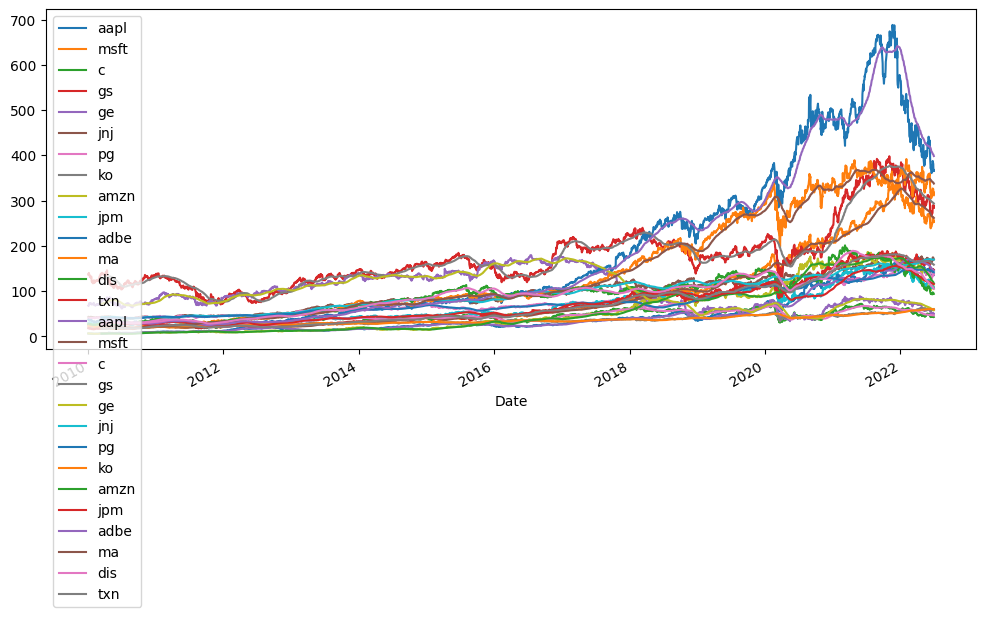

In [3]:
sma = data.rolling(50).mean()

plot = bt.merge(data, sma).plot(figsize=(12, 5))

In [4]:
st = time.time()
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True
    
signal = data > sma


# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)
et = time.time()

print(f"Run time: {et-st:.2f} seconds") 
bt_runtime_seconds = et-st
res.display()

Run time: 1.42 seconds
Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2022-06-30
Risk-free rate       0.00%

Total Return         262.07%
Daily Sharpe         0.70
Daily Sortino        1.06
CAGR                 10.85%
Max Drawdown         -31.75%
Calmar Ratio         0.34

MTD                  -13.76%
3m                   -24.47%
6m                   -26.27%
YTD                  -26.12%
1Y                   -29.33%
3Y (ann.)            2.06%
5Y (ann.)            4.92%
10Y (ann.)           12.00%
Since Incep. (ann.)  10.85%

Daily Sharpe         0.70
Daily Sortino        1.06
Daily Mean (ann.)    11.73%
Daily Vol (ann.)     16.78%
Daily Skew           -0.71
Daily Kurt           5.40
Best Day             5.27%
Worst Day            -8.03%

Monthly Sharpe       0.69
Monthly Sortino      1.09
Monthly Mean (ann.)  11.91%
Monthly Vol (ann.)   17.16%
Monthly Skew         -0.89
Monthly Kurt         1.75
Best Month          

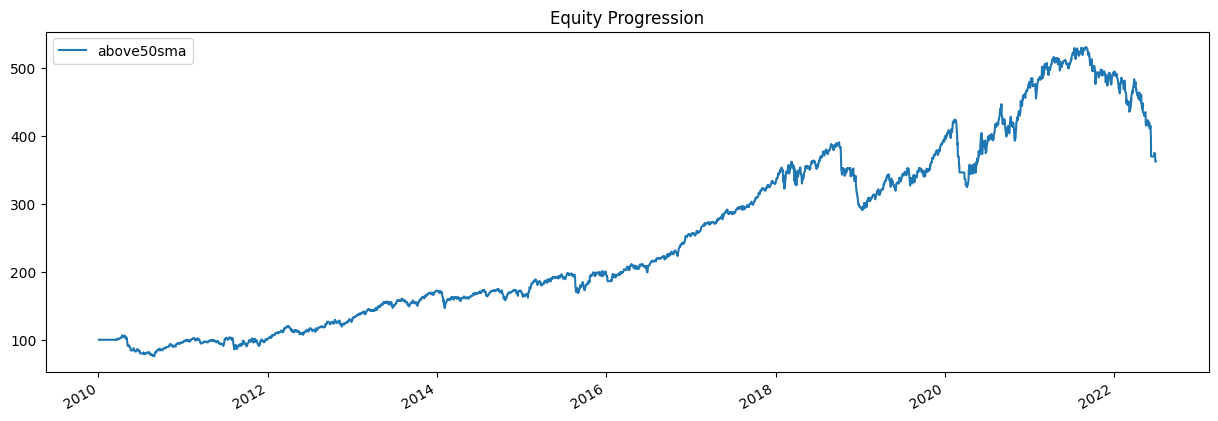

In [5]:
# what does the equity curve look like?
res.plot();

In [48]:
atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Release"
sys.path.append(atlas_path)

from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy import TracerType
from AtlasPy.ast import AssetReadNode, AssetDifferenceNode, AssetQuotientNode, \
      ExchangeViewNode, AllocationNode, StrategyNode, AssetOpNodeVariant, \
            ExchangeViewFilterType, AllocationType

In [72]:
exchange_id = "test"
portfolio_id = "test_p"
strategy_id = "test_s"
exchange_path_fast = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/test/data_sp500.h5"
initial_cash = 100.0
hydra = Hydra()

In [73]:
exchange = hydra.addExchange(exchange_id, exchange_path_fast)
portfolio = hydra.addPortfolio(portfolio_id, exchange, initial_cash)
hydra.build()

In [74]:
time_sum = 0
n = 1
for i in range(n):
    st = time.perf_counter_ns()
    read_close = AssetReadNode.make("close", 0, exchange)
    read_50_ma = AssetReadNode.make("50_ma", 0, exchange)
    spread = AssetDifferenceNode(read_close, read_50_ma)
    op_variant = AssetOpNodeVariant(spread)

    exchange_view = ExchangeViewNode(exchange, op_variant)
    exchange_view.setFilter(ExchangeViewFilterType.GREATER_THAN, 0.0)
    allocation = AllocationNode(exchange_view)
    strategy_node = StrategyNode(allocation, portfolio)
    strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node, 1.0))
    strategy.enableTracerHistory(TracerType.NLV)
    hydra.run()
    et = time.perf_counter_ns()
    time_sum += et - st

avg_time_micros = (time_sum / n) / 1000

tr = (strategy.getNLV() - initial_cash) / initial_cash
print(f"Time elapsed Avg: {avg_time_micros:.3f} us")
print(f"Total return: {tr:.3%}")
print(f"Epsilon: {tr - 2.6207}")

Time elapsed Avg: 753.400 us
Total return: 262.109%
Epsilon: 0.0003877146672262022


In [12]:
bt_runtime_micros = bt_runtime_seconds * 1000000
speedup = bt_runtime_micros / avg_time_micros
print(f"Speedup: {speedup:.3f}x")

Speedup: 3676.123x


C:\Users\natha\AppData\Local\Temp\ipykernel_24084\2118328846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Atlas"] = strategy.getHistory(TracerType.NLV)


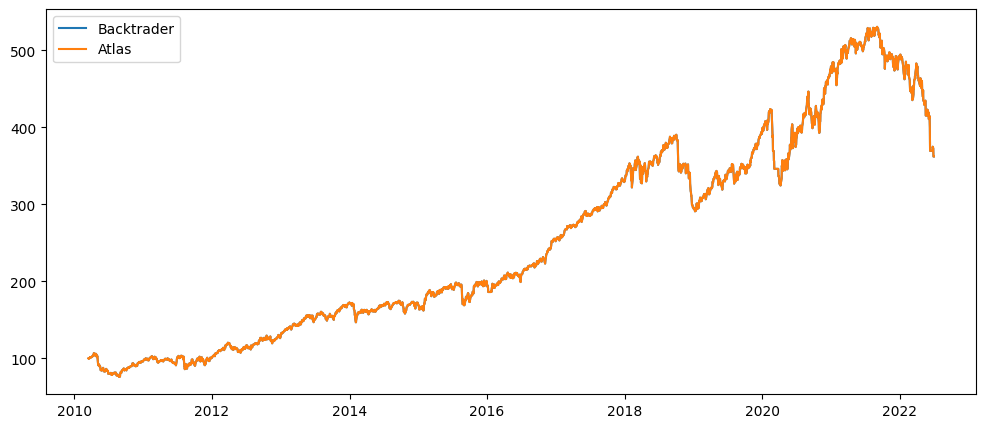

In [13]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

df_res = res.prices.iloc[50:]
df_res["Atlas"] = strategy.getHistory(TracerType.NLV)

ax.plot(df_res["above50sma"], label='Backtrader')
ax.plot(df_res["Atlas"], label='Atlas')

ax.legend()

In [14]:
tickers_new = 'aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn'
data = bt.get(tickers_new, start='2010-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()
data.shape

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3535, 14)

In [81]:
class WeighTarget(bt.Algo):
    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            target.temp['weights'] = w.dropna()

        return True
    
st = time.time()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()

# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0

# divide by row sum to normalize
tw = tw.div(tw.abs().sum(axis=1), axis=0)

# replace nans with 0.0
tw[sma200.isnull()] = 0.0

ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)
et = time.time()
print(f"Run time: {et-st:.2f} seconds")
res.display()

Run time: 2.27 seconds
Stat                 ma_cross
-------------------  ----------
Start                2010-01-03
End                  2024-01-19
Risk-free rate       0.00%

Total Return         110.16%
Daily Sharpe         0.47
Daily Sortino        0.70
CAGR                 5.43%
Max Drawdown         -31.51%
Calmar Ratio         0.17

MTD                  0.50%
3m                   0.57%
6m                   -1.65%
YTD                  0.50%
1Y                   4.57%
3Y (ann.)            5.59%
5Y (ann.)            1.47%
10Y (ann.)           5.04%
Since Incep. (ann.)  5.43%

Daily Sharpe         0.47
Daily Sortino        0.70
Daily Mean (ann.)    6.18%
Daily Vol (ann.)     13.28%
Daily Skew           -0.79
Daily Kurt           22.81
Best Day             10.29%
Worst Day            -10.27%

Monthly Sharpe       0.50
Monthly Sortino      0.78
Monthly Mean (ann.)  6.05%
Monthly Vol (ann.)   12.05%
Monthly Skew         -0.76
Monthly Kurt         1.75
Best Month           9.55%
Worst Mo

<Axes: title={'center': 'Equity Progression'}>

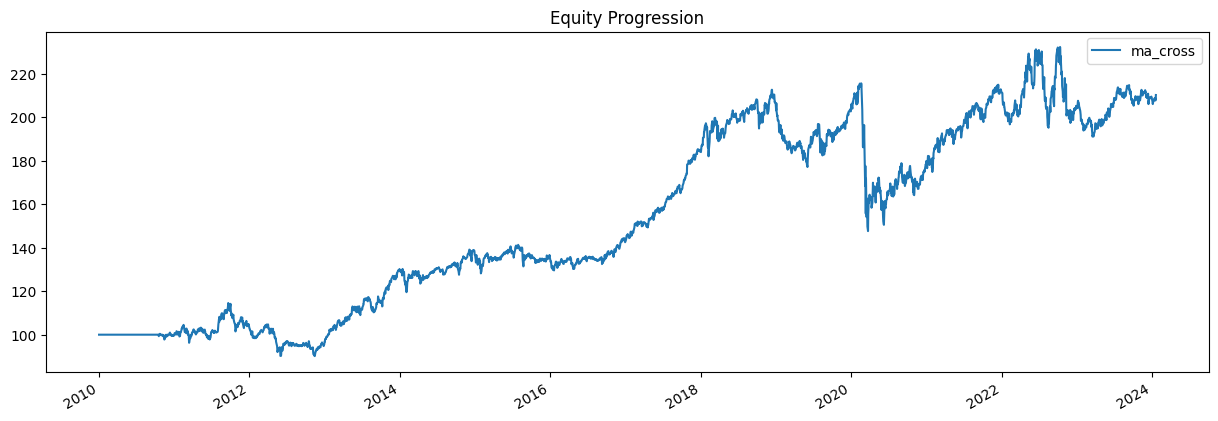

In [82]:
res.plot()

In [17]:
output_path = os.path.join(os.getcwd(), 'data_sp500_ma.h5')
if os.path.exists(output_path):
    os.remove(output_path)
    
for ticker in data.columns:
    df = data[ticker].to_frame()
    df["slow_ma"] = sma200[ticker]
    df["fast_ma"] = sma50[ticker]

    with h5py.File(output_path, "a") as file:
        stock_data = df.to_numpy()
        df.columns = ["close", "slow_ma", "fast_ma"]
        index = df.index.values.astype('int64')
        dataset = file.create_dataset(f"{ticker}/data", data=stock_data)
        file.create_dataset(
                f"{ticker}/datetime",
                data = index,
        )
        for column in df.columns:
            dataset.attrs[column] = column

In [83]:
hydra = Hydra()
exchange = hydra.addExchange(exchange_id, output_path)
portfolio = hydra.addPortfolio(portfolio_id, exchange, initial_cash)
hydra.build()

In [84]:
slow_ma = AssetReadNode.make("slow_ma", 0, exchange)
fast_ma = AssetReadNode.make("fast_ma", 0, exchange)
spread = AssetDifferenceNode(fast_ma, slow_ma)
op_variant = AssetOpNodeVariant(spread)

exchange_view = ExchangeViewNode(exchange, op_variant)
allocation = AllocationNode(exchange_view, AllocationType.CONDITIONAL_SPLIT, 0.0, 0.0)
strategy_node = StrategyNode(allocation, portfolio)
strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node, 1.0))
strategy.enableTracerHistory(TracerType.NLV)

In [85]:
time_sum = 0
n = 1
for i in range(n):
    st = time.perf_counter_ns()
    hydra.run()
    et = time.perf_counter_ns()
    time_sum += et - st

avg_time_micros = (time_sum / n) / 1000

tr = (strategy.getNLV() - initial_cash) / initial_cash
print(f"Time elapsed Avg: {avg_time_micros:.3f} us")
print(f"Total return: {tr:.3%}")
print(f"Epsilon: {tr - 1.1016}")

Time elapsed Avg: 725.500 us
Total return: 110.305%
Epsilon: 0.0014539039503378426


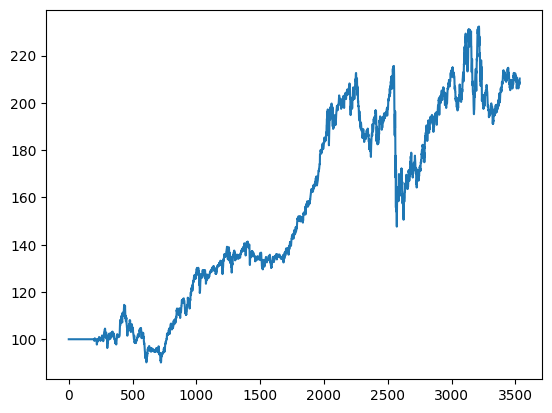

In [86]:
atlas = strategy.getHistory(TracerType.NLV)
plt.plot(atlas)

C:\Users\natha\AppData\Local\Temp\ipykernel_24084\3759711916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results["Atlas"] = strategy.getHistory(TracerType.NLV)


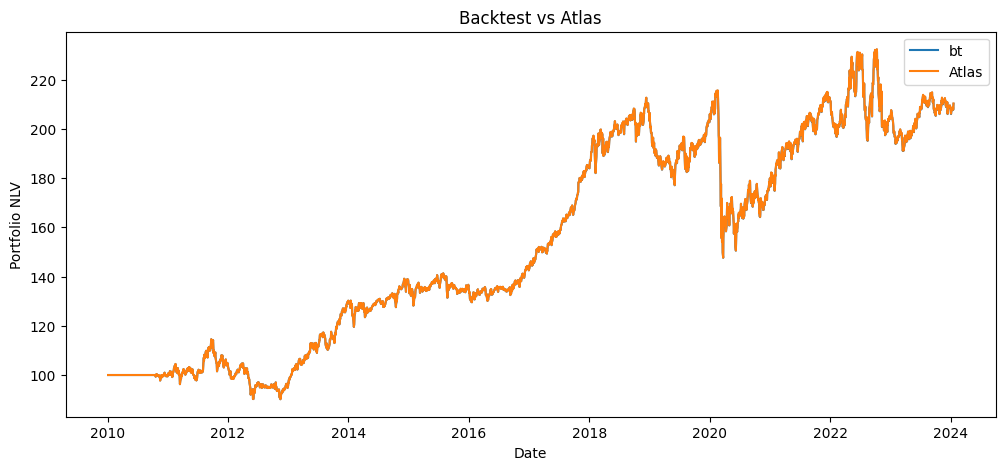

In [95]:
df_results = res.prices
df_results = df_results.iloc[1:]
df_results["Atlas"] = strategy.getHistory(TracerType.NLV)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.plot(df_results["ma_cross"], label='bt')
ax.plot(df_results["Atlas"], label='Atlas')

ax.set_xlabel('Date')
ax.set_ylabel('Portfolio NLV')
plt.title('Backtest vs Atlas')

_ = ax.legend()